In [2]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!pip install yfinance


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [13]:

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Step 1: Fetch AAPL data using yfinance
def fetch_data(ticker, period="1y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    data['Price_Change'] = data['Close'].diff()
    data.dropna(inplace=True)
    print(data.head)
    return data

# Step 2: Preprocessing
def preprocess_data(data, look_back=10):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(data['Price_Change'].values[i])
    
    X, y = np.array(X), np.array(y)
    y = np.expand_dims(y, axis=1)  # Make y 2D for compatibility with TensorFlow
    return X, y, scaler

# Step 3: Build the LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Step 4: Main workflow
if __name__ == "__main__":
    ticker = "AAPL"
    data = fetch_data(ticker)
    
    look_back = 10  # Number of past days to consider for each prediction
    X, y, scaler = preprocess_data(data, look_back=look_back)
    
    # Split into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Build and train the LSTM model
    model = build_lstm(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    
    # Predictions
    predictions = model.predict(X_test)

    # Inverse transform only the target column
    price_change_scaler = MinMaxScaler(feature_range=(0, 1))
    price_change_scaler.min_, price_change_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
    predictions = price_change_scaler.inverse_transform(predictions)

    # Add predictions to the data
    data['Predicted_Price_Change'] = np.nan
    data.iloc[train_size + look_back:, -1] = predictions.flatten()
    print(data.tail())

[*********************100%***********************]  1 of 1 completed

<bound method NDFrame.head of Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2023-12-15  196.606827  197.570007  198.399994  197.000000  197.529999   
2023-12-18  194.934998  195.889999  196.630005  194.389999  196.089996   
2023-12-19  195.979904  196.940002  196.949997  195.889999  196.160004   
2023-12-20  193.880188  194.830002  197.679993  194.830002  196.899994   
2023-12-21  193.730881  194.679993  197.080002  193.500000  196.100006   
...                ...         ...         ...         ...         ...   
2024-12-09  246.750000  246.750000  247.240005  241.750000  241.830002   
2024-12-10  247.770004  247.770004  248.210007  245.339996  246.889999   
2024-12-11  246.490005  246.490005  250.800003  246.259995  247.960007   
2024-12-12  247.960007  247.960007  248.740005  245.679993  246.889999   
2024-12-


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 8.9632 - val_loss: 5.8344
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5864 - val_loss: 5.7348
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6708 - val_loss: 5.6908
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.2008 - val_loss: 5.6873
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.8611 - val_loss: 5.7137
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2271 - val_loss: 5.7557
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1536 - val_loss: 5.8201
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5161 - val_loss: 5.8161
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.1241 - val_loss: 5.8026
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9892 - val_loss: 5.7479
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.7667 - val_loss: 5.6972
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3967 - val_loss: 5.7294
Epoch 13/2

[*********************100%***********************]  1 of 1 completed

Sample Close prices: Ticker            AAPL
Date                  
2023-12-14  198.110001
2023-12-15  197.570007
2023-12-18  195.889999
2023-12-19  196.940002
2023-12-20  194.830002
Epoch 1/20



/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 12.6960 - val_loss: 5.8314
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 9.4616 - val_loss: 5.8113
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.5683 - val_loss: 5.7759
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.6110 - val_loss: 5.7271
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.9784 - val_loss: 5.7152
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.3355 - val_loss: 5.7175
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2503 - val_loss: 5.7248
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3052 - val_loss: 5.7157
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11.1027 - val_loss: 5.7222
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.1897 - val_loss: 5.7275
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1181 - val_loss: 5.7296
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.4573 - val_loss: 5.7223
Epoch 13

/tmp/ipykernel_2424/3410566918.py:62: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predictions = np.cumsum(predictions) + float(last_close_price)  # Start with the last known price


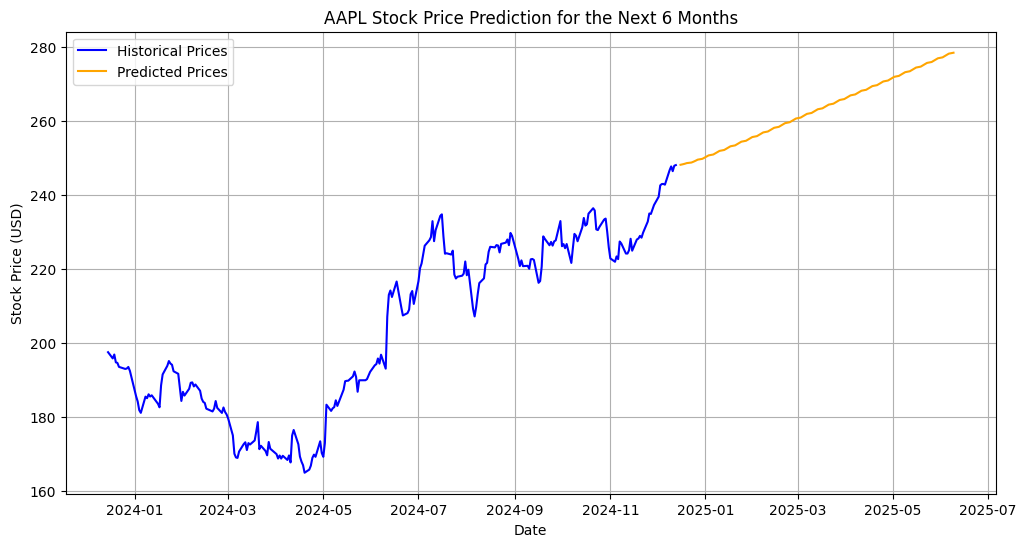

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Fetch historical data
def fetch_data(ticker, period="1y", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    
    # Debug: Check if Close prices are loaded correctly
    print("Sample Close prices:", data['Close'].head())
    
    # Calculate target variable (price change)
    data['Price_Change'] = data['Close'].diff()
    data.dropna(inplace=True)
    return data

# Preprocess the data
def preprocess_data(data, look_back=10):
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(data['Price_Change'].values[i])  # Predict price changes
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Build the LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Predict future prices
def predict_future(model, last_sequence, future_steps, scaler, last_close_price):
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(future_steps):
        pred = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        pred_reshaped = pred.flatten()  # Ensure it's a 1D array

        # Add prediction as a new row with the correct number of features
        new_row = np.zeros((1, current_sequence.shape[1]))
        new_row[0, -1] = pred_reshaped[0]  # Fill in only the predicted column

        # Append the new row and drop the first row
        current_sequence = np.append(current_sequence[1:], new_row, axis=0)
        predictions.append(pred_reshaped[0])
    
    # Convert predictions (price changes) to stock prices
    predictions = np.array(predictions)
    predictions = np.cumsum(predictions) + float(last_close_price)  # Start with the last known price

    return predictions

# Main workflow
if __name__ == "__main__":
    ticker = "AAPL"
    data = fetch_data(ticker)
    look_back = 10

    X, y, scaler = preprocess_data(data, look_back=look_back)
    
    # Split into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build and train the LSTM model
    model = build_lstm(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict the next 6 months
    future_steps = 126  # Approximately 6 months (21 trading days per month)
    last_sequence = X[-1]  # Use the last sequence from the dataset
    last_close_price = data['Close'].iloc[-1]  # Start predictions from the last close price
    future_prices = predict_future(model, last_sequence, future_steps, scaler, last_close_price)

    # Create a future date range
    last_date = data.index[-1]
    future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='B')[1:]

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label="Historical Prices", color="blue")
    plt.plot(future_dates, future_prices, label="Predicted Prices", color="orange")
    plt.title("AAPL Stock Price Prediction for the Next 6 Months")
    plt.xlabel("Date")
    plt.ylabel("Stock Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error
import numpy as np

# Function to calculate F1-Score, RMSE, and MAE
def evaluate_model(y_true, y_pred, threshold=0):
    # Convert predictions to binary for F1-Score calculation (e.g., positive/negative changes)
    y_true_binary = (y_true > threshold).astype(int)
    y_pred_binary = (y_pred > threshold).astype(int)
    
    # F1-Score
    f1 = f1_score(y_true_binary, y_pred_binary, average='macro')
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    return f1, rmse, mae

# Make predictions for test data
y_test_pred = model.predict(X_test).flatten()

# Inverse transform to get the original scale
price_change_scaler = MinMaxScaler(feature_range=(0, 1))
price_change_scaler.min_, price_change_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
y_test = price_change_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred = price_change_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# Evaluate the model
f1, rmse, mae = evaluate_model(y_test, y_test_pred)

# Print the results
print(f"F1-Score: {f1:.4f}")
#print(f"RMSE: {rmse:.4f}")
#print(f"MAE: {mae:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
F1-Score: 0.3797
